In [101]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import astropy.units as u
import scipy.integrate as integrate
import os, csv

def create_dir(filepath):
    if not os.path.exists(filepath):
        os.makedirs(filepath)

In [94]:
LAT_4fgldr4 = fits.open('BAT_LAT_match_4FGL_info.fits')
LAT_names = LAT_4fgldr4[1].data['LAT_NAME']
LAT_pref_spec = LAT_4fgldr4[1].data['SpectrumType']

LAT_Enorm = LAT_4fgldr4[1].data['Pivot_Energy']
#PWL params
LAT_PWL_idx = LAT_4fgldr4[1].data['PL_Index']
LAT_PWL_norm = LAT_4fgldr4[1].data['PL_Flux_Density']

#LogP params
LAT_LP_idx = LAT_4fgldr4[1].data['LP_Index']
LAT_LP_curv = LAT_4fgldr4[1].data['LP_beta']
LAT_LP_norm = LAT_4fgldr4[1].data['LP_Flux_Density']

#PWLCO
LAT_PWLCO_idx = LAT_4fgldr4[1].data['PLEC_IndexS']
LAT_PWLCO_norm = LAT_4fgldr4[1].data['PLEC_Flux_Density']
LAT_PWLCO_curv = LAT_4fgldr4[1].data['PLEC_ExpfactorS']
LAT_PWLCO_exp_idx = LAT_4fgldr4[1].data['PLEC_Exp_Index']

65


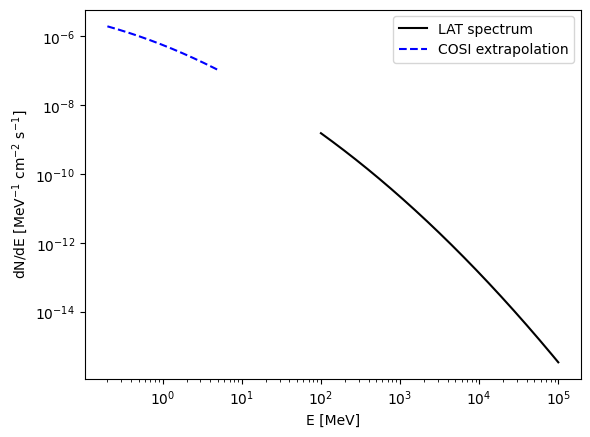

In [95]:
e_LAT = np.linspace(100,100000,100000)*u.MeV
e_COSI = np.linspace(0.2,5,100000)*u.MeV
LAT_spec=[]
COSI_spec=[]
create_dir('extrapolation_figures')

for i in range(len(LAT_names)):
    plt.close('all')
    name = LAT_names[i].replace(" ", "")
    pref_spec=LAT_pref_spec[i]
    e0=LAT_Enorm[i]*u.MeV
    
    if pref_spec=='PowerLaw':
        f0=LAT_PWL_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWL_idx[i]
        
        f_LAT=f0*pow(e_LAT/e0,(-1)*gamma)
        f_COSI=f0*pow(e_COSI/e0,(-1)*gamma)
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)
        
    elif pref_spec=='LogParabola':
        f0=LAT_LP_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_LP_idx[i]
        beta=LAT_LP_curv[i]

        f_LAT=f0*pow(e_LAT/e0,(-1)*(gamma+beta*np.log(e_LAT/e0)))
        f_COSI=f0*pow(e_COSI/e0,(-1)*(gamma+beta*np.log(e_COSI/e0)))
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)
        
    elif pref_spec=='PLSuperExpCutoff':
        f0=LAT_PWLCO_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWLCO_idx[i]
        b=LAT_PWLCO_exp_idx[i]
        d=LAT_PWLCO_curv[i]

        f_LAT=f0*pow(e_LAT/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_LAT/e0,b)))
        f_COSI=f0*pow(e_COSI/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_COSI/e0,b)))
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)

    plt.figure()
    plt.plot(e_LAT,f_LAT,'-k',label='LAT spectrum')
    plt.plot(e_COSI,f_COSI,'--b',label='COSI extrapolation')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('E [MeV]')
    plt.ylabel(r'dN/dE [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
    plt.legend(loc='best')
    plt.savefig('./extrapolation_figures/'+name+'_extrapolation.png')

LAT_spec = np.array(LAT_spec)
COSI_spec = np.array(COSI_spec)


Text(0.5, 0, 'Energy [MeV]')

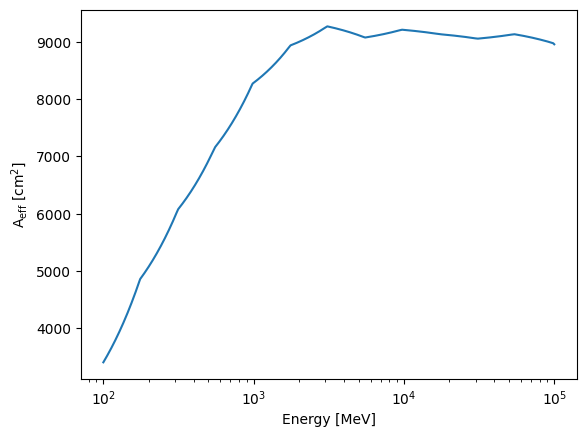

In [96]:
LAT_aeff=np.loadtxt('LAT_aeff.txt')
E_aeff_LAT=LAT_aeff[:,0]*u.MeV
aeff_LAT=LAT_aeff[:,1]*u.Unit('m2')
aeff_LAT=aeff_LAT.to('cm2')

f_interp_LAT = interp1d(E_aeff_LAT,aeff_LAT)
Aeff_LAT_interp = f_interp_LAT(e_LAT)*u.Unit('cm2')

plt.figure()
plt.plot(e_LAT, Aeff_LAT_interp)
plt.xscale('log')
#plt.ylim(0, 120)
plt.ylabel(r'A$_{\rm eff}$ [cm$^2$]')
plt.xlabel('Energy [MeV]')

Text(0.5, 0, 'Energy [MeV]')

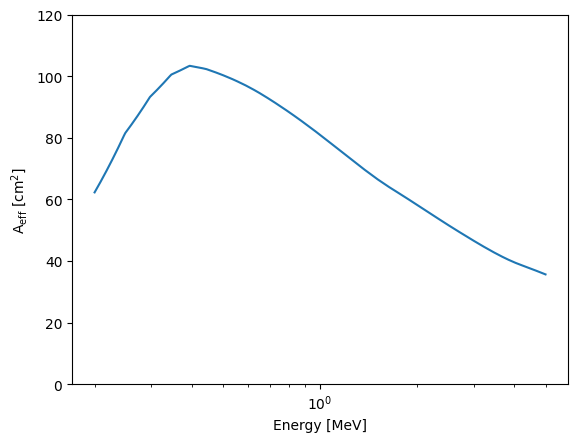

In [97]:
COSI_aeff=np.loadtxt('COSI_aeff.txt')
E_aeff_COSI=COSI_aeff[:,0]*u.keV
aeff_COSI=COSI_aeff[:,1]*u.Unit('cm2')
E_aeff_COSI=E_aeff_COSI.to('MeV')

f_interp_COSI = interp1d(E_aeff_COSI,aeff_COSI)
Aeff_COSI_interp = f_interp_COSI(e_COSI)*u.Unit('cm2')

plt.figure()
plt.plot(e_COSI, Aeff_COSI_interp)
plt.xscale('log')
plt.ylim(0, 120)
plt.ylabel(r'A$_{\rm eff}$ [cm$^2$]')
plt.xlabel('Energy [MeV]')

In [98]:
ph_flux_LAT_all=[]
ph_flux_COSI_all=[]
ratio_all=[]

for i in range(len(LAT_spec)):
    ph_flux_LAT=np.trapz(Aeff_LAT_interp.value * LAT_spec[i], e_LAT.value)
    ph_flux_LAT_all.append(ph_flux_LAT)
    
    ph_flux_COSI=np.trapz(Aeff_COSI_interp.value * COSI_spec[i], e_COSI.value)
    ph_flux_COSI_all.append(ph_flux_COSI)

    ratio=ph_flux_COSI/ph_flux_LAT
    ratio_all.append(ratio)
    

In [103]:
filename = "COSI_LAT_ratios.csv"

# Write to CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Name", "Value"])  # Header

    for name, value in zip(LAT_names, ratio_all):
        writer.writerow([name, value]) 

